In [1]:
%matplotlib inline
import numpy as np
from anisotropic_potential import LayeredHalfspace, apparent_conductivity
from anisotropic_potential_obj import AnisotropicPotentialObjectiveFunction
from objfunc import ModelObjectiveFunction, FCMObjectiveFunction
from utils import eff_anis_trans

import matplotlib.pyplot as plt
from time import time
import scipy.sparse as sp
from scipy.optimize import minimize

from IPython import display

In [2]:
#Setting up model
sig1 = [10**-0.4, 10**-0.9, 10**-0.25]
sig2 = [10**-0.2, 10**-0.3, 10**-0.25]
sig3 = [10**-0.1, 10**-0.0, 10**-0.25]
alpha = [3*np.pi/20, -np.pi/8, 0]
betas = [0, -3*np.pi/8, 0]
gamma = [0, 3*np.pi/8, 0]
zs = [0, 15, 35]

forward_space = LayeredHalfspace(zs, sig1, sig2, sig3, alpha, betas, gamma)

#Setting up observation points
wenner_distances= np.array([-3,-1,1,3])
scales = np.logspace(0,4.5,15)

Axs = wenner_distances[0]*scales
Mxs = wenner_distances[1]*scales
Nxs = wenner_distances[2]*scales
Bxs = wenner_distances[3]*scales
Ays = np.zeros_like(Axs)
Bys = np.zeros_like(Bxs)
Mys = np.zeros_like(Mxs)
Nys = np.zeros_like(Nxs)

#Rotations to perform:
rs = np.array([0, np.pi/4, np.pi/2, 3*np.pi/4])
Xs_a, Ys_a = [],[]
Xs_b, Ys_b = [],[]
Xs_m, Ys_m = [],[]
Xs_n, Ys_n = [],[]
for r in rs:
    rot = np.array([[np.cos(r),-np.sin(r)],[np.sin(r),np.cos(r)]])
    
    x, y = rot@np.c_[Axs, Ays].T
    Xs_a.append(x), Ys_a.append(y)
    
    x, y = rot@np.c_[Bxs, Bys].T
    Xs_b.append(x), Ys_b.append(y)
    
    x, y = rot@np.c_[Mxs, Mys].T
    Xs_m.append(x), Ys_m.append(y)
    
    x, y = rot@np.c_[Nxs, Nys].T
    Xs_n.append(x), Ys_n.append(y)

Ax = np.hstack(Xs_a)
Ay = np.hstack(Ys_a)
Bx = np.hstack(Xs_b)
By = np.hstack(Ys_b)
Mx = np.hstack(Xs_m)
My = np.hstack(Ys_m)
Nx = np.hstack(Xs_n)
Ny = np.hstack(Ys_n)
    
A = np.c_[Ax, Ay].T
B = np.c_[Bx, By].T
M = np.c_[Mx, My].T
N = np.c_[Nx, Ny].T

In [3]:
volts = forward_space.voltage(A, B, M, N)

np.random.seed(1)
d_obs = volts+np.random.randn(*volts.shape)*volts*0.01
Wd = sp.diags(1/(0.01*volts))

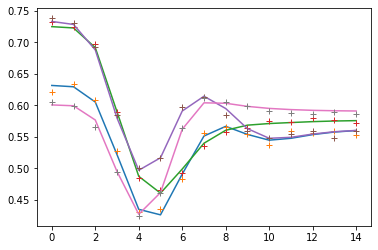

In [4]:
rhoa_true = apparent_conductivity(volts, A, B, M, N)
rhoa_obs = apparent_conductivity(d_obs, A, B, M, N)
for i in range(4):
    plt.plot(rhoa_true[15*i:(i+1)*15], label=i)
    plt.plot(rhoa_obs[15*i:(i+1)*15],'+')

In [5]:
n_inv_layers = 50
s1 = np.ones(n_inv_layers)*10**-.25
s2 = np.ones(n_inv_layers)*10**-.25
s3 = np.ones(n_inv_layers)*10**-.25
a = np.zeros(n_inv_layers)
b = np.zeros(n_inv_layers)
g = np.zeros(n_inv_layers)
zs = np.logspace(0,3,50)-1 #log spaced widths
dz = zs[1:]-zs[:-1]
dz = np.append(dz,dz[-1])

mref = np.concatenate((np.log(s1), np.log(s2), np.log(s3), a, b, g))
mi = mref.copy()
options = {'disp':True}

In [6]:
mod_folder = "Models/mod2/"

In [7]:
PhiD = AnisotropicPotentialObjectiveFunction(zs, (A, B, M, N), d_obs, Wd=Wd)

In [8]:
weights = 1/(np.abs(zs)+1)**2
weights /= weights.max()
weights[-1] = 100
#weights2 = (weights[1:]+weights[:-1])/2

Wz = sp.diags(dz)*sp.diags([-1/dz,1/dz],[0,1],shape=(n_inv_layers,n_inv_layers))
Wz = sp.block_diag([Wz]*3+[Wz]*3).tocsr()
Ws = sp.block_diag([sp.diags(weights*np.sqrt(dz))]*3+[sp.diags(np.sqrt(dz))]*3)

W_anis = sp.diags([-1,-1,2,-1,-1],
                  [-2*n_inv_layers,-n_inv_layers,0,n_inv_layers,2*n_inv_layers],
                  shape=(3*n_inv_layers, 3*n_inv_layers))
W_anis = sp.block_diag((W_anis, sp.csr_matrix(W_anis.shape)))
PhiM = ModelObjectiveFunction(0.25*Ws.T@Ws+100*Wz.T@Wz+1*W_anis, mref=mref)
PhiM2 = ModelObjectiveFunction(100*Wz.T@Wz+1*W_anis, mref=mref)

In [9]:
def callback(x):
    print(0.5*Phi(x), PhiD(x), PhiM(x))

In [10]:
beta = 50
Phi = PhiD+beta*PhiM

x = mi
print(Phi(x), PhiD(x), PhiM(x))
out = minimize(0.5*Phi, x, method='Newton-CG', jac=Phi.d, hessp=lambda xk, p: Phi.H(p),
               options=options, callback=callback, tol=1E-3)
x = out['x']
print('PhiD:', PhiD(x))
np.save(mod_folder + 'beta50',x)

8767.2072164311 8767.2072164311 0.0
2016.362147252906 3769.6733081259963 5.261019727596311
1054.9677703774855 1463.9860820131971 12.918989174835477
729.2524532353907 657.8234770431799 16.01362858855203
678.5362178317849 599.5737878360665 15.14997295655007
673.9320577354297 602.5939336919366 14.905403635578455
670.3945062800708 602.5208785097395 14.765362681008039
669.9867539197893 592.8342510166287 14.942785136458998
669.8161064452521 592.116026617206 14.950323725465964
669.8009555201515 591.3649843533012 14.964738533740036
Optimization terminated successfully.
         Current function value: 669.800956
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
         Hessian evaluations: 77
PhiD: 591.3649843533012


In [11]:
beta = 10
Phi = PhiD+beta*PhiM

x = np.load(mod_folder + 'beta50.npy')
print(Phi(x), PhiD(x), PhiM(x))
out = minimize(0.5*Phi, x, method='Newton-CG', jac=Phi.d, hessp=lambda xk, p: Phi.H(p),
               options=options, callback=callback, tol=1E-3)
x = out['x']
print('PhiD:', PhiD(x))
np.save(mod_folder + 'beta10',x)

741.0123696907016 591.3649843533012 14.964738533740036
302.5409478160489 369.8419773765223 23.52399182555755
261.8332333510813 220.72097265141372 30.294549405074882
248.68807359541012 189.96127882491106 30.741486836590916
245.41904845187923 154.5392944972417 33.62988024065167
245.12833871527872 154.51292032782357 33.57437571027339
244.9696727848726 154.53121432601316 33.54081312437321
244.94305686438753 153.49806237028494 33.63880513584901
Optimization terminated successfully.
         Current function value: 244.943057
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
         Hessian evaluations: 56
PhiD: 153.49806237028494


In [12]:
beta = 2
Phi = PhiD+beta*PhiM

x = np.load(mod_folder + 'beta10.npy')
print(Phi(x), PhiD(x), PhiM(x))
out = minimize(0.5*Phi, x, method='Newton-CG', jac=Phi.d, hessp=lambda xk, p: Phi.H(p),
               options=options, callback=callback)
x = out['x']
print('PhiD:', PhiD(x))
np.save(mod_folder + 'beta2',x)

220.77567264198296 153.49806237028494 33.63880513584901
84.10298703294058 68.1581802675414 50.023896899169884
81.94330107946901 63.661068186249075 50.112766986344475
80.28173508020886 55.497751521110125 52.532859319653795
79.96374048442243 53.47102732597003 53.22822682143741
79.93049048374344 53.37758139549507 53.241699785995905
79.91333425122009 53.23181862372843 53.29742493935588
79.9106968980519 53.214759882084564 53.30331695700961
79.91005025403533 53.24128264498658 53.28940893154203
79.90976563558546 53.21971147196419 53.299909899603364
79.90972073690487 53.23057830326047 53.29443158527464
79.90968859344997 53.2230335504055 53.298171818247226
79.90968537870957 53.22625690800772 53.296556924705705
79.90968260247037 53.22673967996224 53.29631276248925
79.90968232912455 53.226621727018745 53.296371465615174
Optimization terminated successfully.
         Current function value: 79.909682
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
      

In [13]:
#len(PhiD.d_pre)
x = np.load(mod_folder + 'beta2.npy')
print(PhiD(x))

53.226621727018745


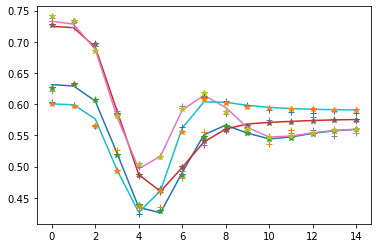

In [14]:
rhoa_pre = apparent_conductivity(PhiD.d_pre, A, B, M, N)
for i in range(4):
    plt.plot(rhoa_true[15*i:(i+1)*15], label=i)
    plt.plot(rhoa_obs[15*i:(i+1)*15],'+')
    plt.plot(rhoa_pre[15*i:(i+1)*15],'*')

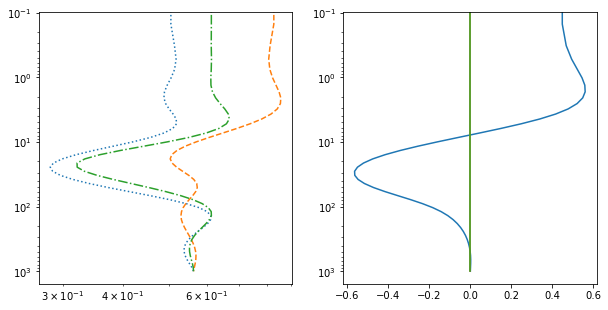

In [15]:
inv1 = np.exp(x.reshape(6,n_inv_layers)[0])
inv2 = np.exp(x.reshape(6,n_inv_layers)[1])
inv3 = np.exp(x.reshape(6,n_inv_layers)[2])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.loglog(inv1, zs,':')
plt.loglog(inv2, zs,"--")
plt.loglog(inv3, zs,"-.")
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.semilogy(x.reshape(6, n_inv_layers)[3], zs)
plt.semilogy(x.reshape(6, n_inv_layers)[4], zs)
plt.semilogy(x.reshape(6, n_inv_layers)[5], zs)
plt.gca().invert_yaxis()

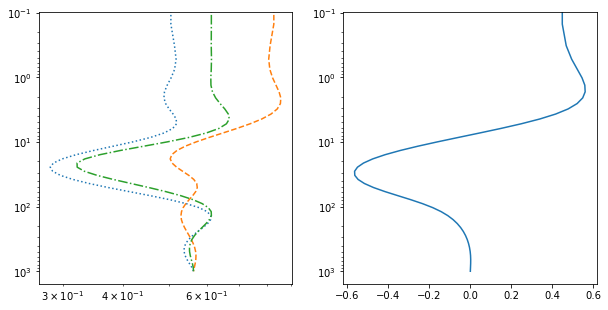

In [16]:
# Plot Effective Anisotropy:
mod = x.reshape(6, n_inv_layers).copy()
mod[:3] = np.exp(mod[:3])
m_eff = eff_anis_trans(*mod)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.loglog(m_eff[0], zs,':')
plt.loglog(m_eff[1], zs,"--")
plt.loglog(m_eff[2], zs,"-.")
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.semilogy(m_eff[3], zs)
plt.gca().invert_yaxis()

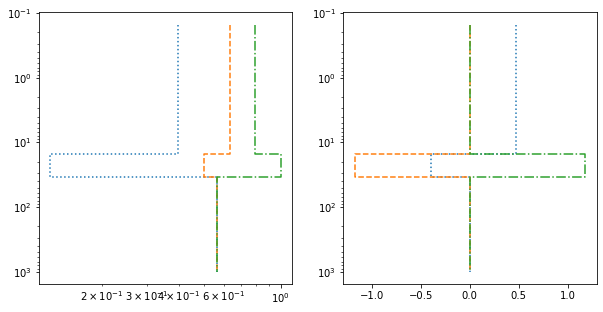

In [17]:
z = forward_space._z
zplot = np.array([zs[1],z[1],z[1],z[2],z[2],zs[-1]])
s1plot = np.array([sig1[0],sig1[0],sig1[1],sig1[1],sig1[2],sig1[2]])
s2plot = np.array([sig2[0],sig2[0],sig2[1],sig2[1],sig2[2],sig2[2]])
s3plot = np.array([sig3[0],sig3[0],sig3[1],sig3[1],sig3[2],sig3[2]])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.loglog(s1plot, zplot, ':')
plt.loglog(s2plot, zplot, "--")
plt.loglog(s3plot, zplot, "-.")
plt.gca().invert_yaxis()

aplot = np.array([alpha[0],alpha[0],alpha[1],alpha[1],alpha[2],alpha[2]])
bplot = np.array([betas[0],betas[0],betas[1],betas[1],betas[2],betas[2]])
gplot = np.array([gamma[0],gamma[0],gamma[1],gamma[1],gamma[2],gamma[2]])
plt.subplot(1,2,2)
plt.semilogy(aplot,zplot,':')
plt.semilogy(bplot,zplot,"--")
plt.semilogy(gplot,zplot,"-.")
plt.gca().invert_yaxis()

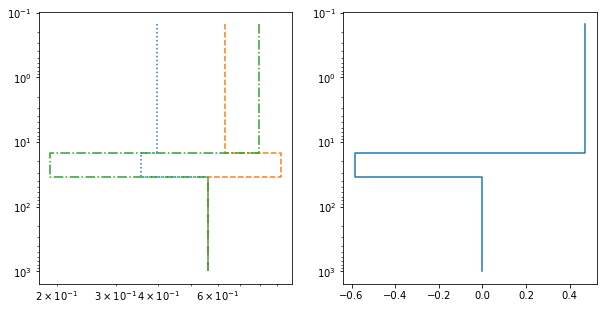

In [18]:
# Plot Effective Anisotropy:

zplot = np.array([zs[1],z[1],z[1],z[2],z[2],zs[-1]])
s1plot = np.array([sig1[0],sig1[0],sig1[1],sig1[1],sig1[2],sig1[2]])
s2plot = np.array([sig2[0],sig2[0],sig2[1],sig2[1],sig2[2],sig2[2]])
s3plot = np.array([sig3[0],sig3[0],sig3[1],sig3[1],sig3[2],sig3[2]])
aplot = np.array([alpha[0],alpha[0],alpha[1],alpha[1],alpha[2],alpha[2]])
bplot = np.array([betas[0],betas[0],betas[1],betas[1],betas[2],betas[2]])
gplot = np.array([gamma[0],gamma[0],gamma[1],gamma[1],gamma[2],gamma[2]])

m_eff = eff_anis_trans(s1plot, s2plot, s3plot, aplot, bplot, gplot)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.loglog(m_eff[0], zplot,':')
plt.loglog(m_eff[1], zplot,"--")
plt.loglog(m_eff[2], zplot,"-.")
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.semilogy(m_eff[3], zplot)
plt.gca().invert_yaxis()

In [19]:
def plot_model(xi, u, i):

    plt.figure(figsize=(15,5))
    
    plt.subplot(1,3,1)
    inv1 = np.exp(xi.reshape(6,n_inv_layers)[0])
    inv2 = np.exp(xi.reshape(6,n_inv_layers)[1])
    inv3 = np.exp(xi.reshape(6,n_inv_layers)[2])
    plt.loglog(inv1, zs,':')
    plt.loglog(inv2, zs,"--")
    plt.loglog(inv3, zs,"-.")
    plt.gca().invert_yaxis()

    plt.subplot(1,3,2)
    plt.semilogy(xi.reshape(6, n_inv_layers)[3], zs,":")
    plt.semilogy(xi.reshape(6, n_inv_layers)[4], zs,"--")
    plt.semilogy(xi.reshape(6, n_inv_layers)[5], zs,"-.")
    plt.gca().invert_yaxis()
    plt.title('Iteration {}'.format(i+1))

    plt.subplot(1,3,3)
    inv1 = u[0]
    inv2 = u[1]
    inv3 = u[2]
    plt.semilogy(inv1, zs,':')
    plt.semilogy(inv2, zs,"--")
    plt.semilogy(inv3, zs,"-.")
    plt.gca().invert_yaxis()

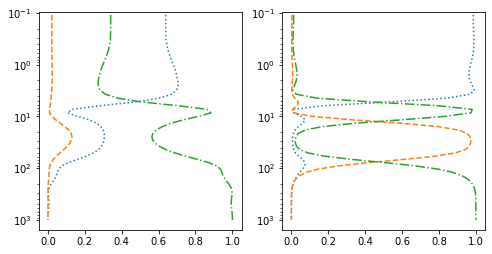

In [20]:
#sig1 = [10**-0.4, 10**-0.9, 10**-0.25]
#sig2 = [10**-0.2, 10**-0.3, 10**-0.25]
#sig3 = [10**-0.1, 10**-0.0, 10**-0.25]
#alpha = [3*np.pi/20, -np.pi/8, 0]
#betas = [0, -3*np.pi/8, 0]
#gamma = [0, 3*np.pi/8, 0]
xi = np.load(mod_folder + 'beta2.npy')
log10 = np.log(10)
tk = np.array([[-0.4*log10, -0.2*log10, -0.1*log10, 3*np.pi/20, 0, 0],
               [-0.9*log10, -0.3*log10, -0*log10, -np.pi/8, -3*np.pi/8, 3*np.pi/8],
               [-0.25*log10, -0.25*log10, -0.25*log10, 0, 0, 0]])
v = tk
PhiFCM = FCMObjectiveFunction(tk, 0)
for i in range(10):
    u = PhiFCM.updateU(xi, v)
    v = PhiFCM.updateV(xi, u, 0)
v_eff = v.copy()
v_eff[:,:3] = np.exp(v_eff[:,:3])
v_eff = np.c_[eff_anis_trans(*v_eff.T)]
v_eff[:, :3] = np.log(v_eff[:,:3])

tk_eff = tk.copy()
tk_eff[:,:3] = np.exp(tk_eff[:,:3])
tk_eff = np.c_[eff_anis_trans(*tk_eff.T)]
tk_eff[:, :3] = np.log(tk_eff[:,:3])

mod = xi.reshape(6, n_inv_layers).copy()
mod[:3] = np.exp(mod[:3])
m_eff = np.r_[eff_anis_trans(*mod)].reshape(4, -1)
m_eff[:3] = np.log(m_eff[:3])
m_eff = m_eff.reshape(-1)

eta = 2

PhiFCM = FCMObjectiveFunction(tk, eta, vi=v, w=[1,1,1,1,1,1])
PhiFCM_eff = FCMObjectiveFunction(tk_eff, eta,  w=np.array([0.01,0.01,0.01,1]))

u = PhiFCM.updateU(xi, tk)
u_eff = PhiFCM_eff.updateU(m_eff, tk_eff)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.semilogy(u[0], zs,':')
plt.semilogy(u[1], zs,"--")
plt.semilogy(u[2], zs,"-.")
plt.gca().invert_yaxis()
plt.subplot(1,2,2)
plt.semilogy(u_eff[0], zs,':')
plt.semilogy(u_eff[1], zs,"--")
plt.semilogy(u_eff[2], zs,"-.")
plt.gca().invert_yaxis()

In [21]:
np.linalg.norm(v-tk), np.linalg.norm(v_eff-tk_eff)

(2.1955171386351147, 0.9708498767025369)

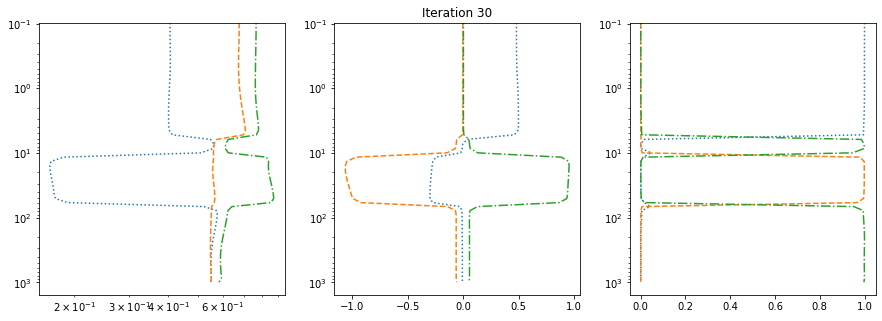

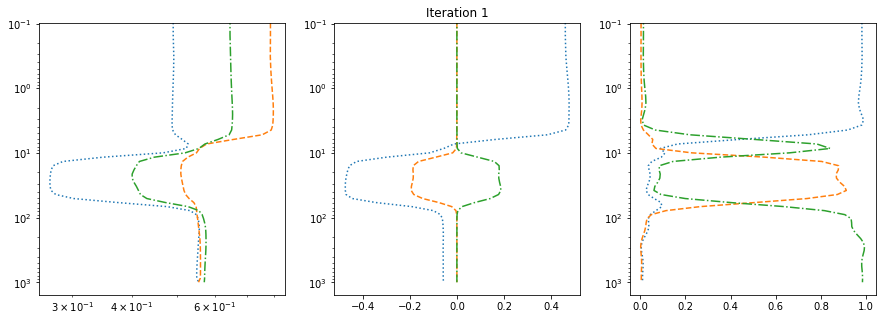

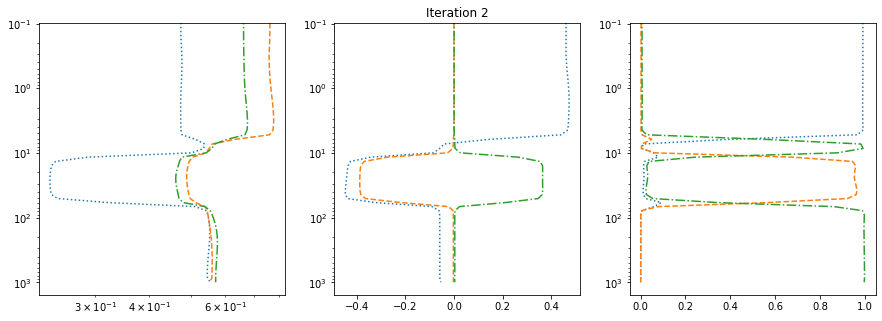

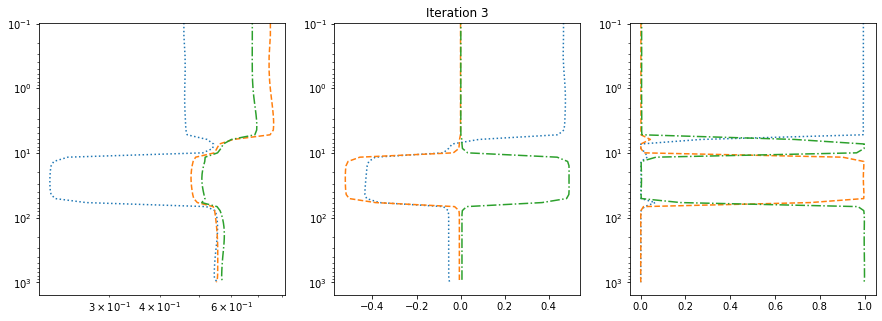

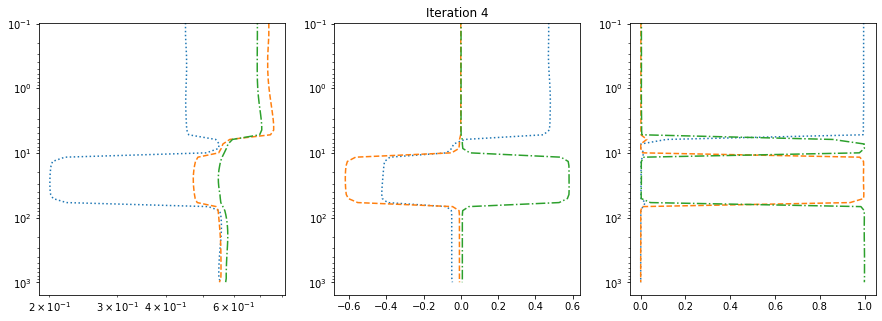

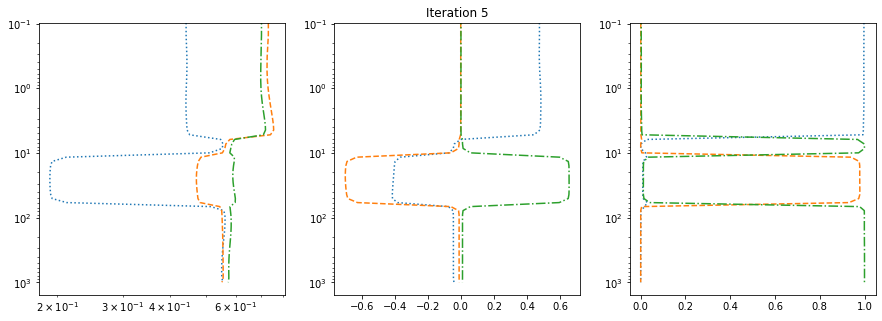

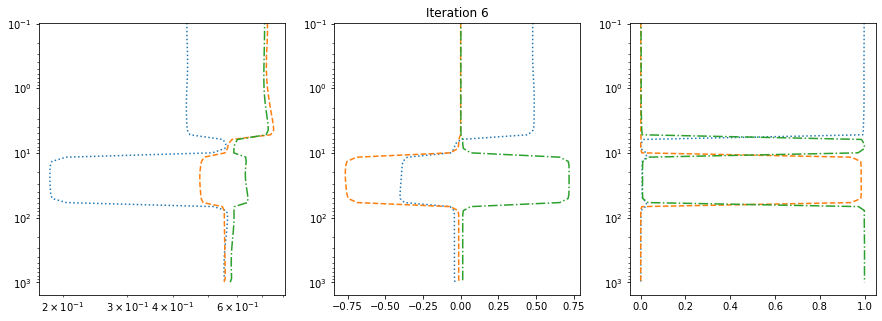

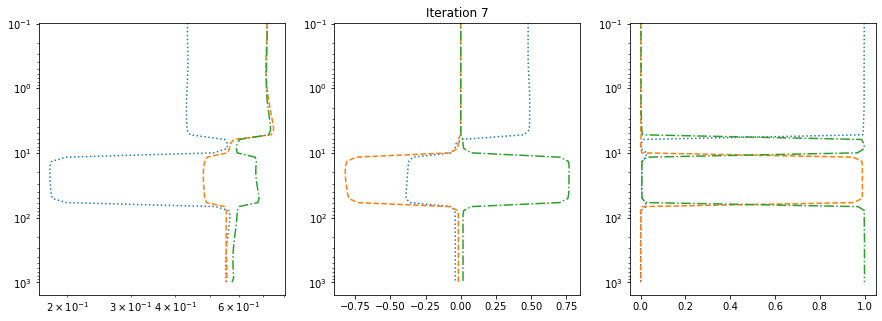

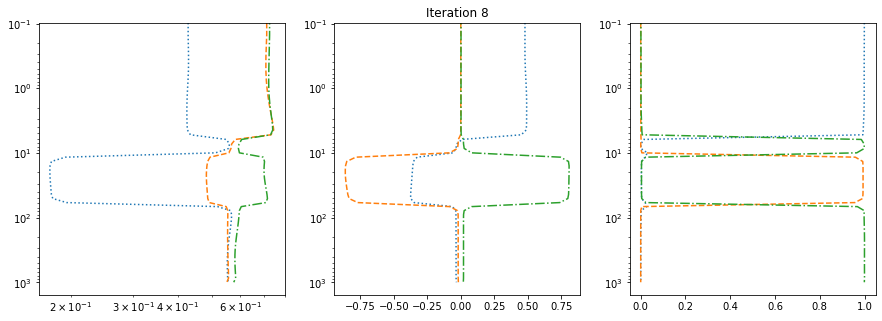

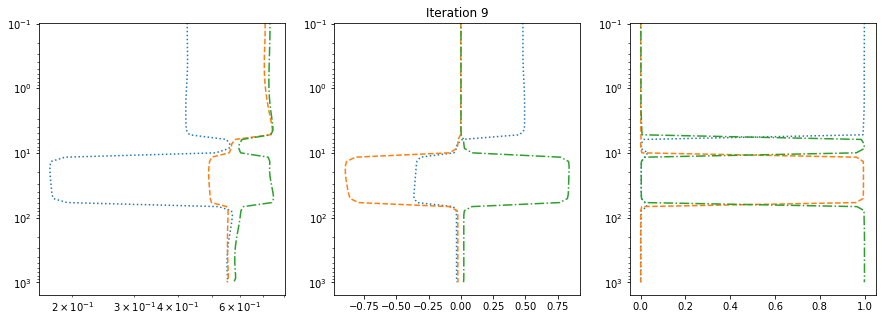

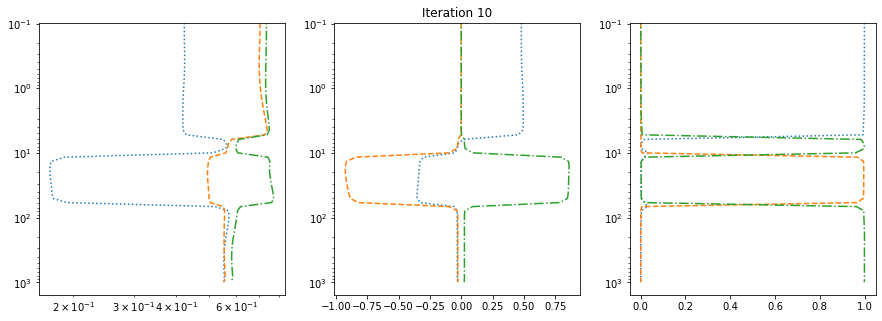

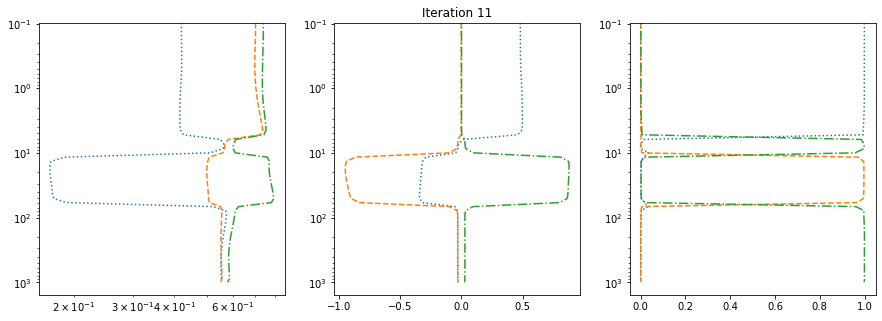

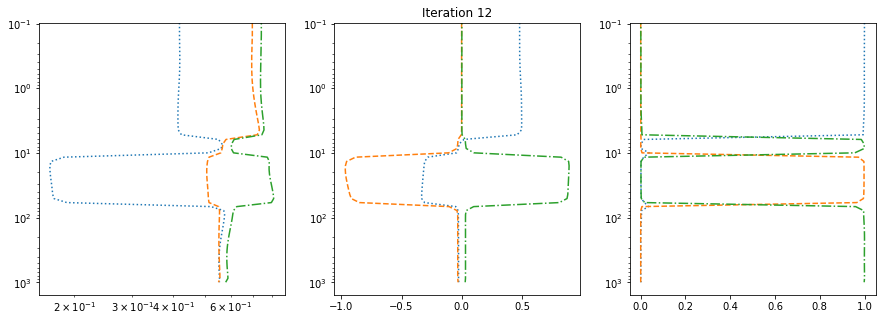

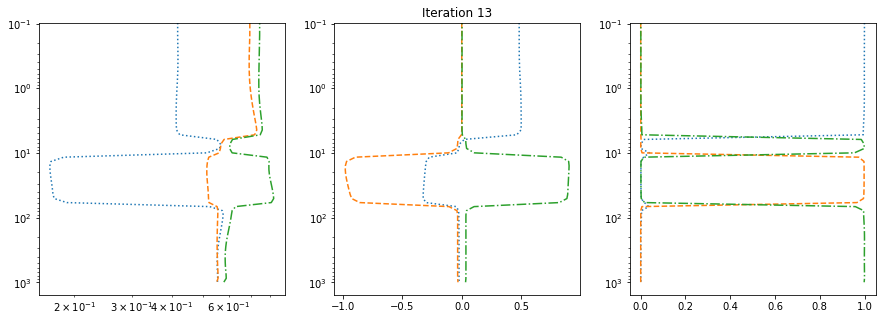

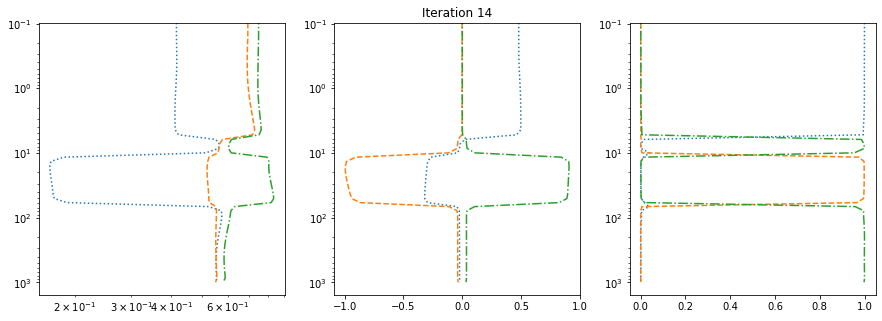

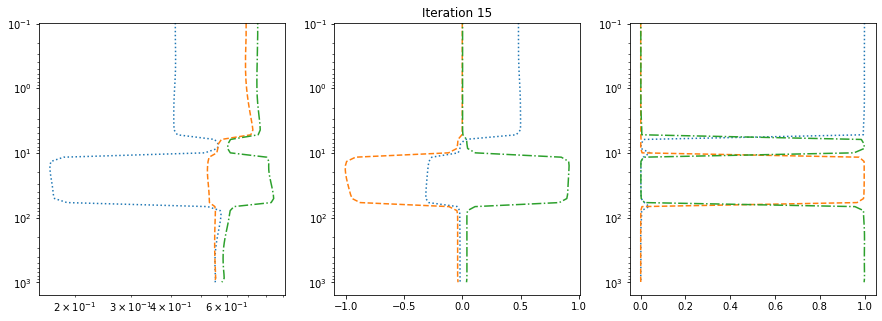

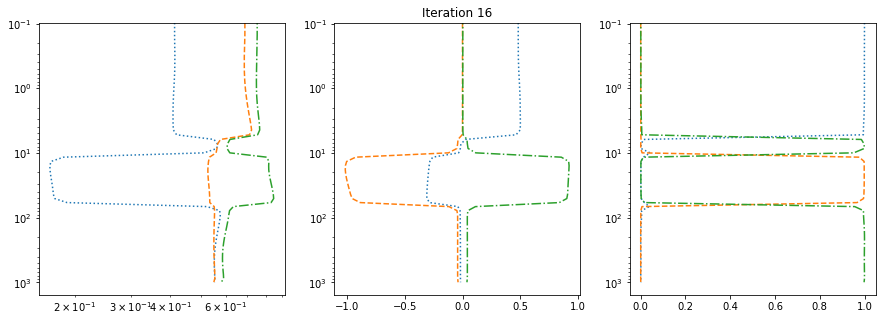

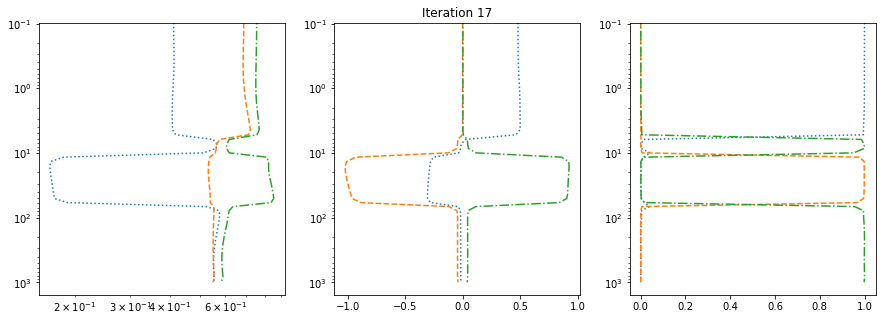

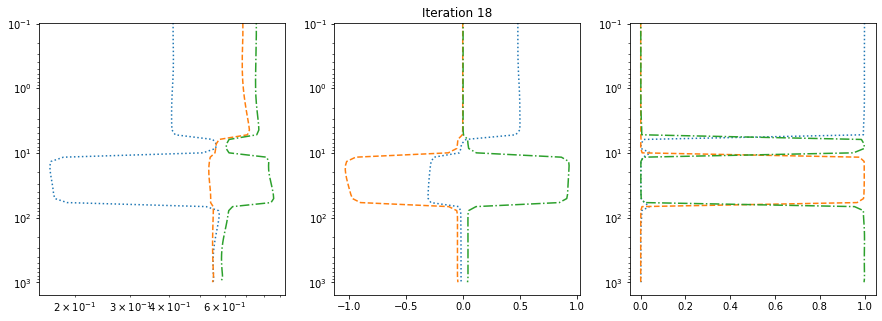

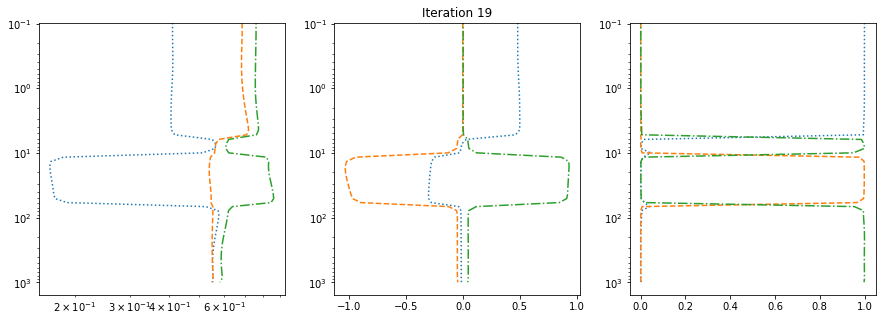

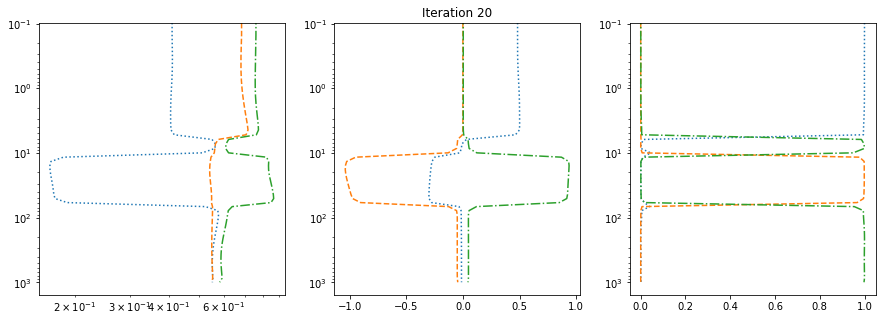

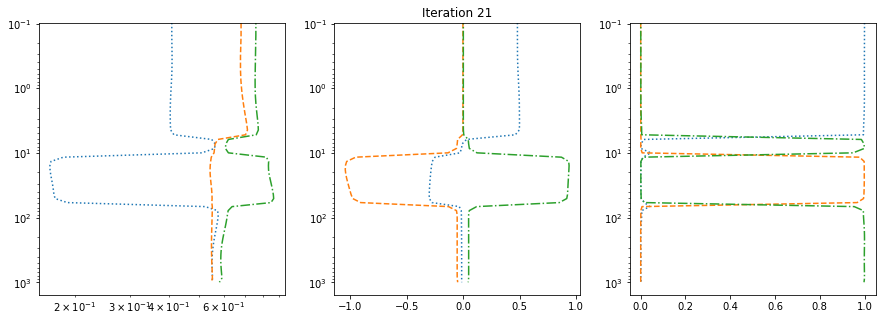

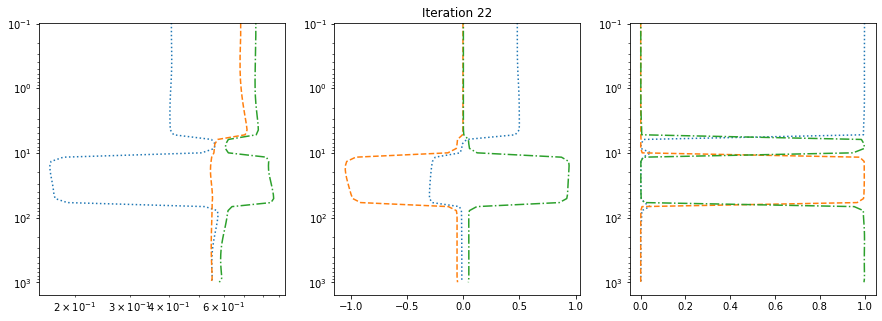

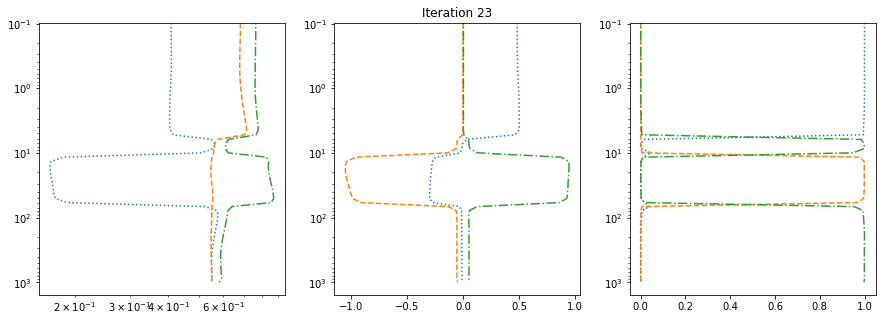

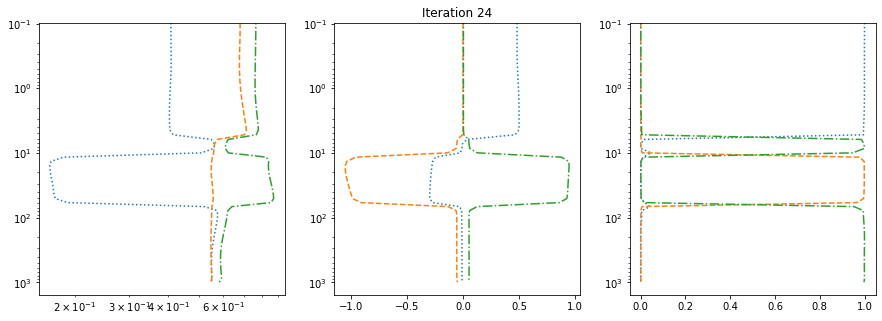

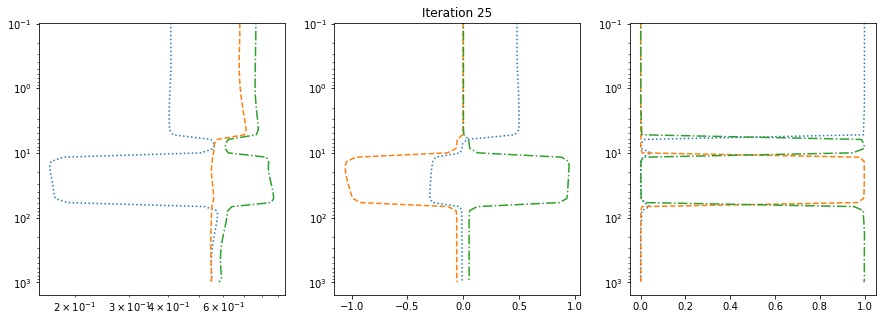

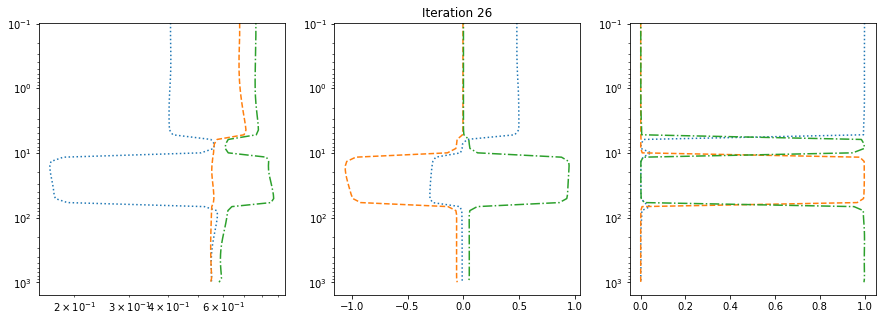

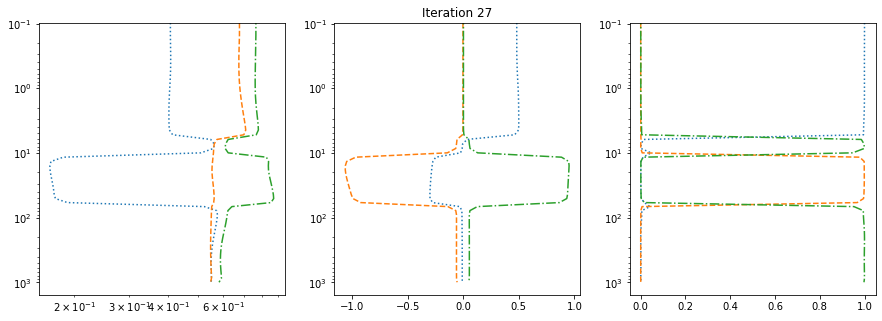

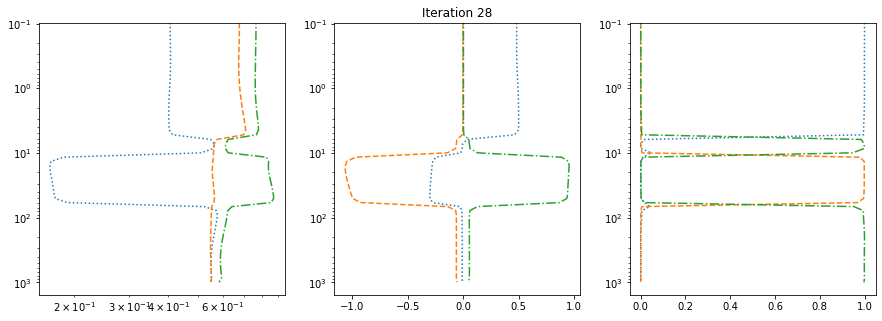

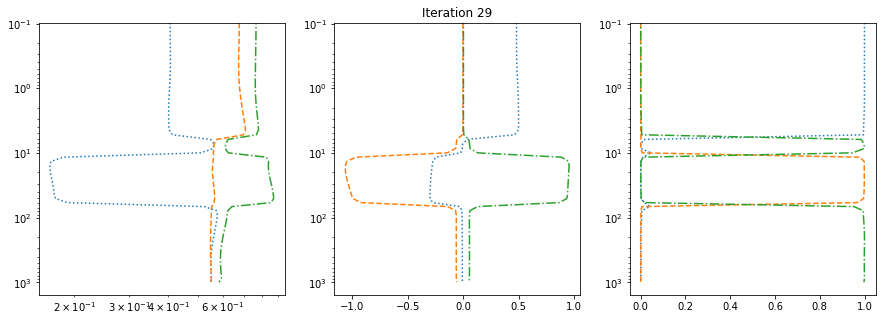

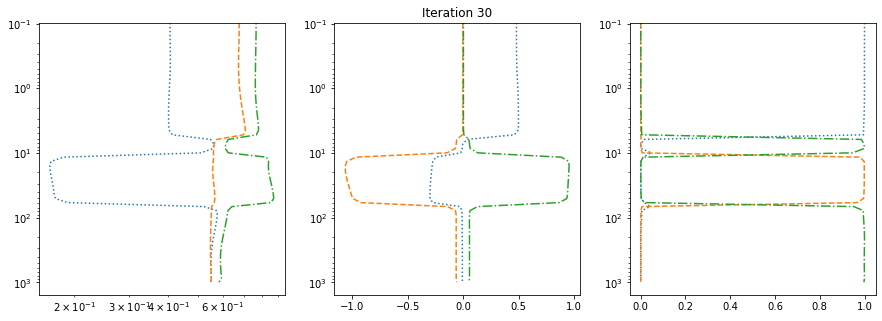

In [22]:
beta = 1.0
lamb = 1000
eta = 2

PhiFCM_eff = FCMObjectiveFunction(tk_eff, eta)
u=PhiFCM_eff.updateU(m_eff, v_eff)

PhiFCM = FCMObjectiveFunction(tk, eta, vi=v)
PhiFCM.u = PhiFCM_eff.u

Phi = PhiD+beta*PhiM2+lamb*PhiFCM

vi = v.copy()
xi = np.load(mod_folder + 'beta2.npy').reshape(-1)
PhiFCM.update_internals()
print(xi.shape)

callback(xi)
phimkm1 = PhiM(xi)
xis = []
for i in range(30):
    #print('Iteration', i+1)
    #if i>6:
    #    eta *= 1.1
        
    ###
    # Update v based on xi and effective and u
    v = PhiFCM.updateV(xi, u, eta)
    v_eff = v.copy()
    v_eff[:,:3] = np.exp(v_eff[:,:3])
    v_eff = np.c_[eff_anis_trans(*v_eff.T)]
    v_eff[:, :3] = np.log(v_eff[:,:3])
    
    m_eff = xi.reshape(6, n_inv_layers).copy()
    m_eff[:3] = np.exp(m_eff[:3])
    m_eff = np.r_[eff_anis_trans(*m_eff)].reshape(4, n_inv_layers)
    m_eff[:3] = np.log(m_eff[:3])
    m_eff = m_eff.reshape(-1)
    
    norm1 = np.linalg.norm(v-tk)
    norm2 = np.linalg.norm(v_eff-tk_eff)
    print(norm1, norm2)
    if norm2<norm1:
        # Update membership using v_eff
        u = PhiFCM_eff.updateU(m_eff, v_eff)
    else:
        u = PhiFCM.updateU(xi.reshape(6, -1), v)
    PhiFCM.u = u
    
    PhiFCM.update_internals()
    ###
    print(v, PhiFCM(xi.reshape(-1)))
    
    Phi = PhiD+beta*PhiM2+lamb*PhiFCM
    
    out = minimize(Phi, xi.reshape(-1), method='Newton-CG', jac=Phi.d, hessp=lambda xk, p: Phi.H(p), tol=1E-2,
                  callback=callback)
    xi = out['x']
    xis.append(xi)
    plot_model(xi, PhiFCM.u, i)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    phimk = PhiM(xi)
    rel_phim = np.abs(phimk-phimkm1)/phimkm1
    #print(rel_phim)
    if(rel_phim<1E-4):
        break
    phimkm1 = phimk
    

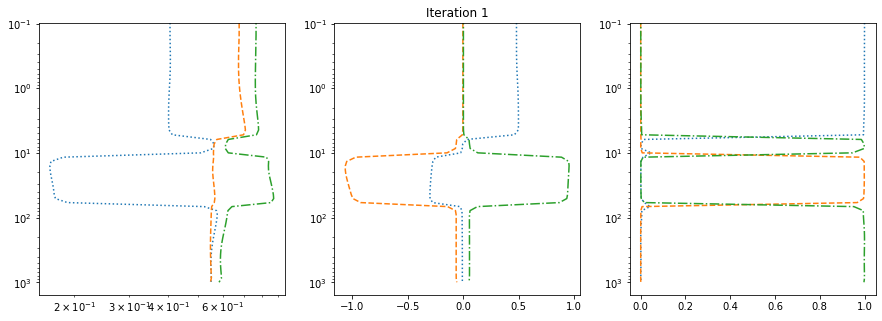

In [23]:
plot_model(xi, PhiFCM.u, 0)

In [24]:
np.linalg.norm(v-tk), np.linalg.norm(v_eff-tk_eff)

(0.43344610720041066, 0.4734076498369876)

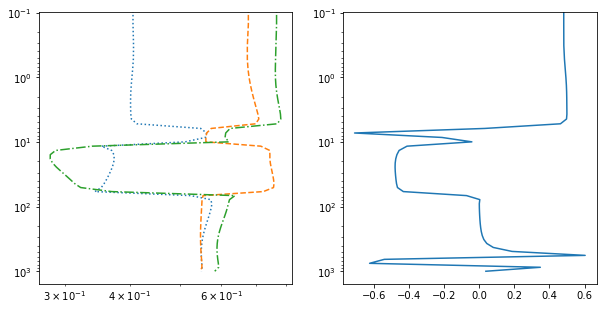

In [25]:
# Plot Effective Anisotropy:
mod = xi.reshape(6, n_inv_layers).copy()
mod[:3] = np.exp(mod[:3])
m_eff = eff_anis_trans(*mod)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.loglog(m_eff[0], zs,':')
plt.loglog(m_eff[1], zs,"--")
plt.loglog(m_eff[2], zs,"-.")
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.semilogy(m_eff[3], zs)
plt.gca().invert_yaxis()

In [26]:
np.save(mod_folder + 'm_fcm_eff',xi)
PhiD(xi)

220.78154496668995

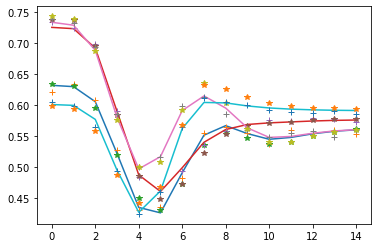

In [27]:
rhoa_pre = apparent_conductivity(PhiD.d_pre, A, B, M, N)
for i in range(4):
    plt.plot(rhoa_true[15*i:(i+1)*15], label=i)
    plt.plot(rhoa_obs[15*i:(i+1)*15],'+')
    plt.plot(rhoa_pre[15*i:(i+1)*15],'*')

In [28]:
x = np.load(mod_folder + 'beta2.npy'); PhiD(xi);
rhoa_pre1 = apparent_conductivity(PhiD.d_pre, A, B, M, N)

x = np.load(mod_folder + 'm_fcm_eff.npy'); PhiD(xi);
rhoa_pre2 = apparent_conductivity(PhiD.d_pre, A, B, M, N)

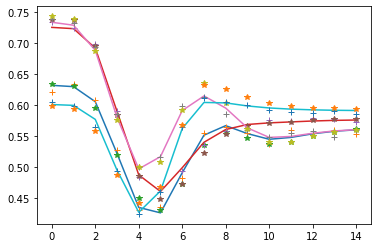

In [29]:
rhoa_pre = apparent_conductivity(PhiD.d_pre, A, B, M, N)
for i in range(4):
    plt.plot(rhoa_true[15*i:(i+1)*15], label=i)
    plt.plot(rhoa_obs[15*i:(i+1)*15],'+')
    plt.plot(rhoa_pre2[15*i:(i+1)*15],'*')

In [30]:
np.savez(mod_folder + 'data',
         rhoa_true=rhoa_true,
         rhoa_obs=rhoa_obs,
         rhoa_smooth=rhoa_pre1,
         rhoa_fcm=rhoa_pre2)